## Module-3

## NLP Clustering on the basis of patients diagnosis extracted from discharge summary 


#### Objective:
  - We will be using NMF model to cluster dignosis names into different groups.
  - Extracting topics is a good unsupervised data-mining technique to discover the underlying relationships between texts.
  - The various diagnosis will be clustered by topic modelling
  - These diagnosis clusters will be combined with the patients labitems information which is a tabular dataset.
  - We will train the second model with this combined data set to check if the clinical text (here - discharge summary of ICU patients who are diagnosed with heart failure) can prvide more insightful information for the Model training.




In [142]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

## Loading the data

 - extract_df.csv was created with the diagnosis names returned by the AWS Comprehend Medical. Hence we added the patient id ("subject_id") and admission id ("hadm_id") columns with this dataset to be used by this notebook.


In [143]:
df_form = pd.read_csv("extract_df.csv")


## Prepare the text for topic modeling

The dataset has 6377 discharge summaries. They are stored in TEXT column.

In [144]:
df_form["TEXT"].value_counts().head(100)

['nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan']                                                                                                                      3027
['stable condition', 'shortness of breath', 'coronary artery disease', 'pain', 'chronic obstructive pulmonary disease', 'depression', 'cough', 'complications', 'sleepy', 'wound']             2
['hypertension', 'atrial fibrillation', 'angina', 'hypercholesterolemia', 'thrombophlebitis', 'pain', 'stenosis', 'coronary artery disease', 'normal sinus rhythm', 'diabetes mellitus']       2
['atrial fibrillation', 'pneumothorax', 'chronic obstructive pulmonary disease', 'prostate cancer', 'pain', 'weakness', 'dry', 'hypertension', 'collapse', 'edema']                            2
['mitral regurgitation', 'hypertension', 'benign prostatic hypertrophy', 'nondistended', 'rub', 'murmur', 'breath sounds are clear', 'obese', 'positive bowel sounds', 'nontender']            2
                                   

In [145]:
df=df_form[['TEXT']]


In [146]:
df

,TEXT
0,"['pain', 'disease', 'lesion', 'shortness of br..."
1,"['nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'na..."
2,"['edema', 'lactic acidosis', 'cardiomyopathy',..."
3,"['fever', 'pna', 'chf', 'disease', 'febrile', ..."
4,"['bleeding', 'ulcers', 'bleed', 'thrombosis', ..."
...,...
6372,"['nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'na..."
6373,"['nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'na..."
6374,"['hyperkalemia', 'alert', 'hypertension', 'hyp..."
6375,"['nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'na..."


## Prepare the text for topic modeling


 - Make text lowercase. The TEXT column is already tokenized by AWS Comprehend Medical, only key words from diagnosis text are stored here.

 - Use POS tags to get relevant words from the texts. Using Nouns just 

 - Lemmatize the texts

In [147]:
df

,TEXT
0,"['pain', 'disease', 'lesion', 'shortness of br..."
1,"['nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'na..."
2,"['edema', 'lactic acidosis', 'cardiomyopathy',..."
3,"['fever', 'pna', 'chf', 'disease', 'febrile', ..."
4,"['bleeding', 'ulcers', 'bleed', 'thrombosis', ..."
...,...
6372,"['nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'na..."
6373,"['nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'na..."
6374,"['hyperkalemia', 'alert', 'hypertension', 'hyp..."
6375,"['nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'na..."


In [148]:
import re, nltk, spacy, string
pd.options.mode.chained_assignment = None  
df.TEXT=df.TEXT.astype(str)
def clean_text(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    # text = re.sub(r'\[.*?\]', '', text)
    # text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    # text = re.sub(r'\w*\d\w*', '', text)
    return text

df_clean = pd.DataFrame(df.TEXT.apply(lambda x: clean_text(x)))

In [149]:
df_clean

,TEXT
0,"['pain', 'disease', 'lesion', 'shortness of br..."
1,"['nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'na..."
2,"['edema', 'lactic acidosis', 'cardiomyopathy',..."
3,"['fever', 'pna', 'chf', 'disease', 'febrile', ..."
4,"['bleeding', 'ulcers', 'bleed', 'thrombosis', ..."
...,...
6372,"['nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'na..."
6373,"['nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'na..."
6374,"['hyperkalemia', 'alert', 'hypertension', 'hyp..."
6375,"['nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'na..."


In [150]:
#Function to Lemmatize the texts
def lemmatizer(text):        
    sent = []
    doc = nlp(text)
    for word in doc:
        sent.append(word.lemma_)
    return " ".join(sent)

In [151]:
#Creating a dataframe that will have only the text and the lemmatized text.
import en_core_web_sm
nlp = en_core_web_sm.load()
df_clean["name_lemmatize"] =  df_clean.apply(lambda x: lemmatizer(x['TEXT']), axis=1)

In [152]:
df_clean

,TEXT,name_lemmatize
0,"['pain', 'disease', 'lesion', 'shortness of br...","[ ' pain ' , ' disease ' , ' lesion ' , ' shor..."
1,"['nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'na...","[ ' nan ' , ' nan ' , ' nan ' , ' nan ' , ' na..."
2,"['edema', 'lactic acidosis', 'cardiomyopathy',...","[ ' edema ' , ' lactic acidosis ' , ' cardiomy..."
3,"['fever', 'pna', 'chf', 'disease', 'febrile', ...","[ ' fever ' , ' pna ' , ' chf ' , ' disease ' ..."
4,"['bleeding', 'ulcers', 'bleed', 'thrombosis', ...","[ ' bleed ' , ' ulcer ' , ' bleed ' , ' thromb..."
...,...,...
6372,"['nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'na...","[ ' nan ' , ' nan ' , ' nan ' , ' nan ' , ' na..."
6373,"['nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'na...","[ ' nan ' , ' nan ' , ' nan ' , ' nan ' , ' na..."
6374,"['hyperkalemia', 'alert', 'hypertension', 'hyp...","[ ' hyperkalemia ' , ' alert ' , ' hypertensio..."
6375,"['nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'na...","[ ' nan ' , ' nan ' , ' nan ' , ' nan ' , ' na..."


In [153]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sarba\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\sarba\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [154]:
!pip install textblob

In [155]:
#Using custom Chunking
#Chunking in NLP is a process to take small pieces of information and group them into large units. The primary use of Chunking is making groups of "noun phrases.
#Here we are using only noun, singular as we have already lemmatized the texts.
import pandas as pd
from textblob import TextBlob

def pos_tag(text):
    try:
        return TextBlob(text).tags
    except:
        return None

def get_adjectives(text):
    blob = TextBlob(text)
    return ' '.join([ word for (word,tag) in blob.tags if tag == "NN"])

df_clean["name_POS_removed"] =  df_clean.apply(lambda x: get_adjectives(x['name_lemmatize']), axis=1)

In [156]:
#Now the clean dataframe .
df_clean

,TEXT,name_lemmatize,name_POS_removed
0,"['pain', 'disease', 'lesion', 'shortness of br...","[ ' pain ' , ' disease ' , ' lesion ' , ' shor...",[ pain disease lesion shortness breath artery ...
1,"['nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'na...","[ ' nan ' , ' nan ' , ' nan ' , ' nan ' , ' na...",[ nan nan nan nan nan nan nan nan nan ]
2,"['edema', 'lactic acidosis', 'cardiomyopathy',...","[ ' edema ' , ' lactic acidosis ' , ' cardiomy...",[ edema acidosis cardiomyopathy shortness brea...
3,"['fever', 'pna', 'chf', 'disease', 'febrile', ...","[ ' fever ' , ' pna ' , ' chf ' , ' disease ' ...",[ fever pna chf disease febrile cough diarrhea...
4,"['bleeding', 'ulcers', 'bleed', 'thrombosis', ...","[ ' bleed ' , ' ulcer ' , ' bleed ' , ' thromb...",[ bleed ulcer bleed thrombosis melena pain ede...
...,...,...,...
6372,"['nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'na...","[ ' nan ' , ' nan ' , ' nan ' , ' nan ' , ' na...",[ nan nan nan nan nan nan nan nan nan ]
6373,"['nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'na...","[ ' nan ' , ' nan ' , ' nan ' , ' nan ' , ' na...",[ nan nan nan nan nan nan nan nan nan ]
6374,"['hyperkalemia', 'alert', 'hypertension', 'hyp...","[ ' hyperkalemia ' , ' alert ' , ' hypertensio...",[ hyperkalemia alert hypertension hyperglycemi...
6375,"['nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'na...","[ ' nan ' , ' nan ' , ' nan ' , ' nan ' , ' na...",[ nan nan nan nan nan nan nan nan nan ]


In [157]:

import nltk.corpus
nltk.download("stopwords")
from nltk.corpus import stopwords


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sarba\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [158]:

stop_words = stopwords.words('english')
df_clean['name_POS_removed'] = df_clean['name_POS_removed'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

## Let’s do some quick exploratory data analysis to get familiar with the data.

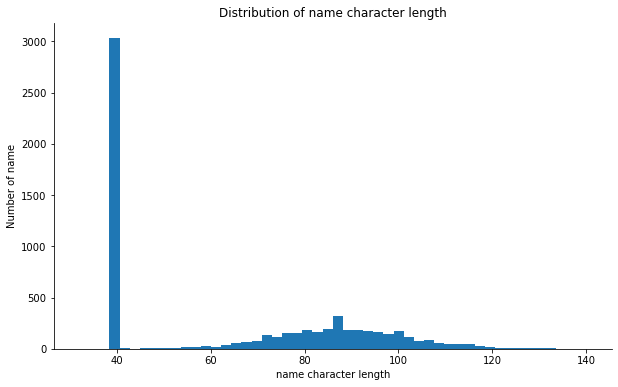

In [159]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px
plt.figure(figsize=(10,6))
doc_lens = [len(d) for d in df_clean.name_POS_removed]
plt.hist(doc_lens, bins = 50)
plt.title('Distribution of name character length')
plt.ylabel('Number of name')
plt.xlabel('name character length')
sns.despine();

In [160]:
#Removing the text whose length i less than 3

print(df_clean.shape)
df_clean = df_clean[df_clean['name_POS_removed'].apply(lambda x: len(str(x)) > 2)]
print(df_clean.shape)

(6377, 3)
(6377, 3)


In [161]:
#doc_lens = [len(d) for d in df_clean.name_POS_removed]

df_clean.name_POS_removed

0       [ pain disease lesion shortness breath artery ...
1                 [ nan nan nan nan nan nan nan nan nan ]
2       [ edema acidosis cardiomyopathy shortness brea...
3       [ fever pna chf disease febrile cough diarrhea...
4       [ bleed ulcer bleed thrombosis melena pain ede...
                              ...                        
6372              [ nan nan nan nan nan nan nan nan nan ]
6373              [ nan nan nan nan nan nan nan nan nan ]
6374    [ hyperkalemia alert hypertension hyperglycemi...
6375              [ nan nan nan nan nan nan nan nan nan ]
6376              [ nan nan nan nan nan nan nan nan nan ]
Name: name_POS_removed, Length: 6377, dtype: object

In [162]:
doc_lens[4]

81

In [163]:
df_clean

,TEXT,name_lemmatize,name_POS_removed
0,"['pain', 'disease', 'lesion', 'shortness of br...","[ ' pain ' , ' disease ' , ' lesion ' , ' shor...",[ pain disease lesion shortness breath artery ...
1,"['nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'na...","[ ' nan ' , ' nan ' , ' nan ' , ' nan ' , ' na...",[ nan nan nan nan nan nan nan nan nan ]
2,"['edema', 'lactic acidosis', 'cardiomyopathy',...","[ ' edema ' , ' lactic acidosis ' , ' cardiomy...",[ edema acidosis cardiomyopathy shortness brea...
3,"['fever', 'pna', 'chf', 'disease', 'febrile', ...","[ ' fever ' , ' pna ' , ' chf ' , ' disease ' ...",[ fever pna chf disease febrile cough diarrhea...
4,"['bleeding', 'ulcers', 'bleed', 'thrombosis', ...","[ ' bleed ' , ' ulcer ' , ' bleed ' , ' thromb...",[ bleed ulcer bleed thrombosis melena pain ede...
...,...,...,...
6372,"['nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'na...","[ ' nan ' , ' nan ' , ' nan ' , ' nan ' , ' na...",[ nan nan nan nan nan nan nan nan nan ]
6373,"['nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'na...","[ ' nan ' , ' nan ' , ' nan ' , ' nan ' , ' na...",[ nan nan nan nan nan nan nan nan nan ]
6374,"['hyperkalemia', 'alert', 'hypertension', 'hyp...","[ ' hyperkalemia ' , ' alert ' , ' hypertensio...",[ hyperkalemia alert hypertension hyperglycemi...
6375,"['nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'na...","[ ' nan ' , ' nan ' , ' nan ' , ' nan ' , ' na...",[ nan nan nan nan nan nan nan nan nan ]


#### Text analysis with visualization

In [164]:
!pip install wordcloud

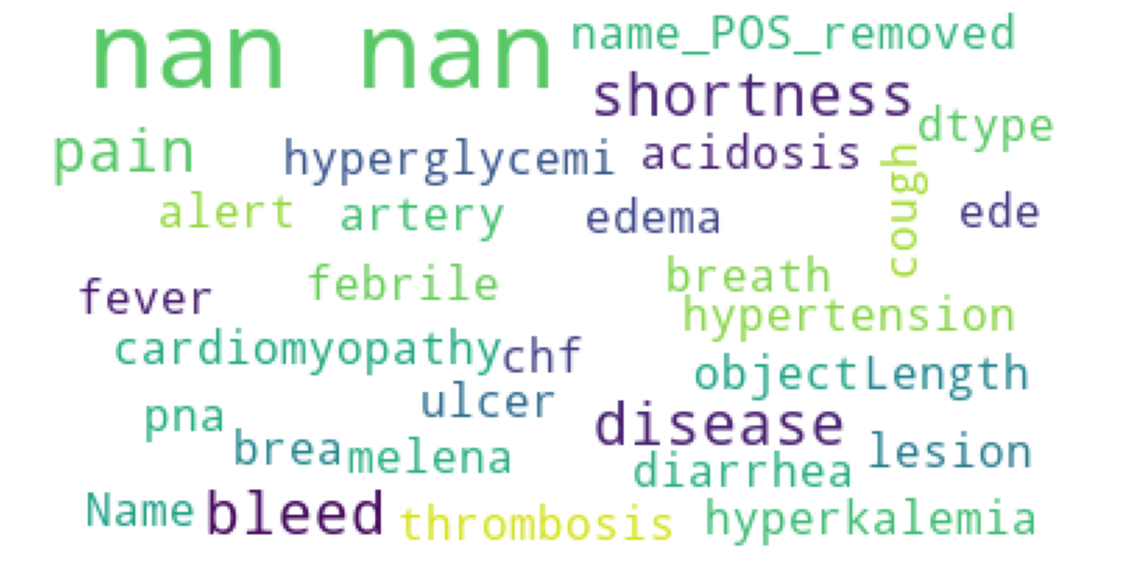

In [165]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS

mpl.rcParams['figure.figsize']=(20.0,20.0)  
mpl.rcParams['font.size']=12            
mpl.rcParams['savefig.dpi']=100             
mpl.rcParams['figure.subplot.bottom']=.1 
stopwords = set(STOPWORDS)

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=70,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(df_clean['name_POS_removed']))

print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show();

In [166]:
#Removing -PRON- from the text corpus
df_clean['name_clean'] = df_clean['name_POS_removed'].str.replace('-PRON-', '')

## Here are the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘

Detect words which are some of the top words which makes sense given the focus of the complaints.

In [167]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(df_clean['name_clean'].values.astype('U'), 50)
df2 = pd.DataFrame(common_words, columns = ['unigram' , 'count'])

fig = go.Figure([go.Bar(x=df2['unigram'], y=df2['count'])])
fig.update_layout(title=go.layout.Title(text="Top 50 unigrams in the Complaint text after removing stop words and lemmatization"))
fig.show()

In [168]:
df2.head(10)

,unigram,count
0,nan,27359
1,pain,2100
2,edema,1114
3,disease,1015
4,failure,991
5,hypertension,804
6,effusion,666
7,bleed,641
8,pneumonia,623
9,fibrillation,574


In [169]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(df_clean['name_clean'].values.astype('U'), 30)
df3 = pd.DataFrame(common_words, columns = ['bigram' , 'count'])
fig = go.Figure([go.Bar(x=df3['bigram'], y=df3['count'])])
fig.update_layout(title=go.layout.Title(text="Top 30 bigrams in the Complaint text after removing stop words and lemmatization"))
fig.show()

In [170]:
df3.head(5)

,bigram,count
0,nan nan,24302
1,heart failure,474
2,shortness breath,458
3,artery disease,384
4,stage disease,89


In [171]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_trigram(df_clean['name_clean'].values.astype('U'), 30)
df4 = pd.DataFrame(common_words, columns = ['trigram' , 'count'])
fig = go.Figure([go.Bar(x=df4['trigram'], y=df4['count'])])
fig.update_layout(title=go.layout.Title(text="Top 30 trigrams in the text"))
fig.show()

In [172]:
df4.head(10)

,trigram,count
0,nan nan nan,21251
1,pain shortness breath,50
2,pain heart failure,39
3,pain artery disease,38
4,disease heart failure,30
5,edema heart failure,29
6,heart failure hypertension,26
7,failure artery disease,25
8,shortness breath edema,24
9,hypertension heart failure,23


## Lets now convert the raw texts to a matrix of TF-IDF features

max_df is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

min_df is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [173]:
tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

## Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [174]:
dtm = tfidf.fit_transform(df_clean['name_clean'])

## NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In [175]:
from sklearn.decomposition import NMF

## Coherence Model to select best number of Topics
With the Coherence Model we will see how to automatically select the best number of topics. 


In [176]:
import warnings
warnings.filterwarnings("ignore")
from gensim.corpora.dictionary import Dictionary

In [177]:
!python -m pip install -U gensim


In [178]:
from gensim.models.nmf import Nmf
from gensim.models.coherencemodel import CoherenceModel
from operator import itemgetter

In [179]:


# Use Gensim's NMF to get the best num of topics via coherence score
texts = df_clean['name_clean']
dataset = [d.split() for d in texts]

# Create a dictionary
# In gensim a dictionary is a mapping between words and their integer id
dictionary = Dictionary(dataset)

# Filter out extremes to limit the number of features
dictionary.filter_extremes(
    no_below=3,
    no_above=0.85,
    keep_n=5000
)

# Create the bag-of-words format (list of (token_id, token_count))
corpus = [dictionary.doc2bow(text) for text in dataset]

# Create a list of the topic numbers we want to try
topic_nums = list(np.arange(5, 10, 1))

# Run the nmf model and calculate the coherence score
# for each number of topics
coherence_scores = []

for num in topic_nums:
    nmf = Nmf(
        corpus=corpus,
        num_topics=num,
        id2word=dictionary,
        chunksize=2000,
        passes=7,
        kappa=.1,
        minimum_probability=0.01,
        w_max_iter=900,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=42
    )
    
    # Run the coherence model to get the score
    cm = CoherenceModel(
        model=nmf,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    coherence_scores.append(round(cm.get_coherence(), 5))

# Get the number of topics with the highest coherence score
scores = list(zip(topic_nums, coherence_scores))
best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

print(best_num_topics)

5


## Manual Topic Modeling
With the CoherenceModel we got the best number of topics=5.The hard work is already done at this point so all we need to do is run the model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [180]:
nmf_model = NMF(n_components=5,random_state=40)

In [181]:
nmf_model.fit(dtm)
len(tfidf.get_feature_names())

854

In [182]:
#Print the top word of a sample component
single_topic = nmf_model.components_[0]
single_topic.argsort()
top_word_indices = single_topic.argsort()[-10:]
for index in top_word_indices:
    print(tfidf.get_feature_names()[index])

complication
sepsis
paralysis
work
thrombocytosis
infection
candidemia
tract
condition
nan


#Print Top15 words for each of the topics

In [183]:
#Print Top15 words for each of the topics
for index,topic in enumerate(nmf_model.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([tfidf.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC #0
['nodule', 'saturation', 'oxygen', 'fibrillation', 'troponin', 'complication', 'sepsis', 'paralysis', 'work', 'thrombocytosis', 'infection', 'candidemia', 'tract', 'condition', 'nan']


THE TOP 15 WORDS FOR TOPIC #1
['stenosis', 'constipation', 'thicken', 'diarrhea', 'nausea', 'sepsis', 'anemia', 'pneumonia', 'hypotension', 'infection', 'edema', 'bleed', 'fever', 'effusion', 'pain']


THE TOP 15 WORDS FOR TOPIC #2
['hypercholesterolemia', 'occlude', 'insufficiency', 'patent', 'lesion', 'rhythm', 'fibrillation', 'stage', 'infarction', 'mellitus', 'pain', 'hypertension', 'stenosis', 'artery', 'disease']


THE TOP 15 WORDS FOR TOPIC #3
['afib', 'cardiomyopathy', 'dyspnea', 'pain', 'function', 'hypotension', 'insufficiency', 'anemia', 'pneumonia', 'regurgitation', 'hypertension', 'edema', 'fibrillation', 'heart', 'failure']


THE TOP 15 WORDS FOR TOPIC #4
['fibrillation', 'nausea', 'regurgitation', 'sob', 'constipation', 'symptom', 'distress', 'pneumonia', 'dy

In [184]:
#Creating the best topic for each complaint
topic_results = nmf_model.transform(dtm)
topic_results[0].round(2)
topic_results[0].argmax()
topic_results.argmax(axis=1)

array([2, 0, 4, ..., 1, 0, 0], dtype=int64)

In [185]:
#Assign the best topic to each of the cmplaints in Topic Column
df_clean['Topic'] = topic_results.argmax(axis=1)

In [186]:
df_clean.head()

,TEXT,name_lemmatize,name_POS_removed,name_clean,Topic
0,"['pain', 'disease', 'lesion', 'shortness of br...","[ ' pain ' , ' disease ' , ' lesion ' , ' shor...",[ pain disease lesion shortness breath artery ...,[ pain disease lesion shortness breath artery ...,2
1,"['nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'na...","[ ' nan ' , ' nan ' , ' nan ' , ' nan ' , ' na...",[ nan nan nan nan nan nan nan nan nan ],[ nan nan nan nan nan nan nan nan nan ],0
2,"['edema', 'lactic acidosis', 'cardiomyopathy',...","[ ' edema ' , ' lactic acidosis ' , ' cardiomy...",[ edema acidosis cardiomyopathy shortness brea...,[ edema acidosis cardiomyopathy shortness brea...,4
3,"['fever', 'pna', 'chf', 'disease', 'febrile', ...","[ ' fever ' , ' pna ' , ' chf ' , ' disease ' ...",[ fever pna chf disease febrile cough diarrhea...,[ fever pna chf disease febrile cough diarrhea...,1
4,"['bleeding', 'ulcers', 'bleed', 'thrombosis', ...","[ ' bleed ' , ' ulcer ' , ' bleed ' , ' thromb...",[ bleed ulcer bleed thrombosis melena pain ede...,[ bleed ulcer bleed thrombosis melena pain ede...,1


In [187]:
#Print the first 5 question for each of the Topics
df_dc=df_clean.groupby('Topic').head(5)
df_dc.sort_values('Topic')

,TEXT,name_lemmatize,name_POS_removed,name_clean,Topic
1,"['nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'na...","[ ' nan ' , ' nan ' , ' nan ' , ' nan ' , ' na...",[ nan nan nan nan nan nan nan nan nan ],[ nan nan nan nan nan nan nan nan nan ],0
18,"['nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'na...","[ ' nan ' , ' nan ' , ' nan ' , ' nan ' , ' na...",[ nan nan nan nan nan nan nan nan nan ],[ nan nan nan nan nan nan nan nan nan ],0
17,"['nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'na...","[ ' nan ' , ' nan ' , ' nan ' , ' nan ' , ' na...",[ nan nan nan nan nan nan nan nan nan ],[ nan nan nan nan nan nan nan nan nan ],0
16,"['nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'na...","[ ' nan ' , ' nan ' , ' nan ' , ' nan ' , ' na...",[ nan nan nan nan nan nan nan nan nan ],[ nan nan nan nan nan nan nan nan nan ],0
15,"['nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'na...","[ ' nan ' , ' nan ' , ' nan ' , ' nan ' , ' na...",[ nan nan nan nan nan nan nan nan nan ],[ nan nan nan nan nan nan nan nan nan ],0
12,"['cancer', 'pain', 'warm', 'masses', 'wounds',...","[ ' cancer ' , ' pain ' , ' warm ' , ' masse '...",[ cancer pain masse wound constipation cardiom...,[ cancer pain masse wound constipation cardiom...,1
3,"['fever', 'pna', 'chf', 'disease', 'febrile', ...","[ ' fever ' , ' pna ' , ' chf ' , ' disease ' ...",[ fever pna chf disease febrile cough diarrhea...,[ fever pna chf disease febrile cough diarrhea...,1
4,"['bleeding', 'ulcers', 'bleed', 'thrombosis', ...","[ ' bleed ' , ' ulcer ' , ' bleed ' , ' thromb...",[ bleed ulcer bleed thrombosis melena pain ede...,[ bleed ulcer bleed thrombosis melena pain ede...,1
6,"['emphysema', 'respiratory distress', 'pneumon...","[ ' emphysema ' , ' respiratory distress ' , '...",[ emphysema distress pneumonia effusion hypoki...,[ emphysema distress pneumonia effusion hypoki...,1
9,"['pain', 'bleeding', 'drainage', 'claudication...","[ ' pain ' , ' bleed ' , ' drainage ' , ' clau...",[ pain bleed drainage claudication swell disco...,[ pain bleed drainage claudication swell disco...,1


In [188]:
df_clean

,TEXT,name_lemmatize,name_POS_removed,name_clean,Topic
0,"['pain', 'disease', 'lesion', 'shortness of br...","[ ' pain ' , ' disease ' , ' lesion ' , ' shor...",[ pain disease lesion shortness breath artery ...,[ pain disease lesion shortness breath artery ...,2
1,"['nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'na...","[ ' nan ' , ' nan ' , ' nan ' , ' nan ' , ' na...",[ nan nan nan nan nan nan nan nan nan ],[ nan nan nan nan nan nan nan nan nan ],0
2,"['edema', 'lactic acidosis', 'cardiomyopathy',...","[ ' edema ' , ' lactic acidosis ' , ' cardiomy...",[ edema acidosis cardiomyopathy shortness brea...,[ edema acidosis cardiomyopathy shortness brea...,4
3,"['fever', 'pna', 'chf', 'disease', 'febrile', ...","[ ' fever ' , ' pna ' , ' chf ' , ' disease ' ...",[ fever pna chf disease febrile cough diarrhea...,[ fever pna chf disease febrile cough diarrhea...,1
4,"['bleeding', 'ulcers', 'bleed', 'thrombosis', ...","[ ' bleed ' , ' ulcer ' , ' bleed ' , ' thromb...",[ bleed ulcer bleed thrombosis melena pain ede...,[ bleed ulcer bleed thrombosis melena pain ede...,1
...,...,...,...,...,...
6372,"['nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'na...","[ ' nan ' , ' nan ' , ' nan ' , ' nan ' , ' na...",[ nan nan nan nan nan nan nan nan nan ],[ nan nan nan nan nan nan nan nan nan ],0
6373,"['nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'na...","[ ' nan ' , ' nan ' , ' nan ' , ' nan ' , ' na...",[ nan nan nan nan nan nan nan nan nan ],[ nan nan nan nan nan nan nan nan nan ],0
6374,"['hyperkalemia', 'alert', 'hypertension', 'hyp...","[ ' hyperkalemia ' , ' alert ' , ' hypertensio...",[ hyperkalemia alert hypertension hyperglycemi...,[ hyperkalemia alert hypertension hyperglycemi...,1
6375,"['nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'na...","[ ' nan ' , ' nan ' , ' nan ' , ' nan ' , ' na...",[ nan nan nan nan nan nan nan nan nan ],[ nan nan nan nan nan nan nan nan nan ],0


### Saving the clustered data in CSV format to be used by Notebook-4 to train the new model along with tabular lab records.

In [189]:
training_data=df_clean[["TEXT","Topic"]]

In [190]:
training_data.to_csv("dxcode-cluster.csv")

In [191]:
training_data

,TEXT,Topic
0,"['pain', 'disease', 'lesion', 'shortness of br...",2
1,"['nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'na...",0
2,"['edema', 'lactic acidosis', 'cardiomyopathy',...",4
3,"['fever', 'pna', 'chf', 'disease', 'febrile', ...",1
4,"['bleeding', 'ulcers', 'bleed', 'thrombosis', ...",1
...,...,...
6372,"['nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'na...",0
6373,"['nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'na...",0
6374,"['hyperkalemia', 'alert', 'hypertension', 'hyp...",1
6375,"['nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'na...",0


In [123]:
import pickle
from sklearn.feature_extraction.text import CountVectorizer


#GET VECTOR COUNT
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(training_data.TEXT)

#SAVE WORD VECTOR
pickle.dump(count_vect.vocabulary_, open("count_vector.pkl","wb"))

In [124]:
from sklearn.feature_extraction.text import TfidfTransformer

#TRANSFORM WORD VECTOR TO TF IDF
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

#SAVE TF-IDF
pickle.dump(tfidf_transformer, open("tfidf.pkl","wb"))

In [125]:
# Multinomial Naive Bayes

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.Topic, test_size=0.25, random_state=42)
clf = MultinomialNB().fit(X_train, y_train)

#SAVE MODEL
pickle.dump(clf, open("nb_model.pkl", "wb"))

In [126]:
import pickle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

target_names = ["Topic1","Topic2","Topic3","Topic4", "Topic5"]

docs_new = "'effusion', 'dilated', 'pneumonia', 'edema', 'pain', 'systolic function', 'hypokinesis', 'troponin leak', 'tricuspid regurgitation', 'thickened'"
docs_new = [docs_new]

#LOAD MODEL
loaded_vec = CountVectorizer(vocabulary=pickle.load(open("count_vector.pkl", "rb")))
loaded_tfidf = pickle.load(open("tfidf.pkl","rb"))
loaded_model = pickle.load(open("nb_model.pkl","rb"))

X_new_counts = loaded_vec.transform(docs_new)
X_new_tfidf = loaded_tfidf.transform(X_new_counts)
predicted = loaded_model.predict(X_new_tfidf)

print(target_names[predicted[0]])

Topic2


In [127]:
predicted = loaded_model.predict(X_test)
result_bayes = pd.DataFrame( {'true_labels': y_test,'predicted_labels': predicted})

#for predicted_item, result in zip(predicted, y_test):
 #   print(target_names[predicted_item], ' - ', target_names[result])

In [128]:
from sklearn.metrics import confusion_matrix  
from sklearn.metrics import f1_score

confusion_mat = confusion_matrix(y_test,predicted)
print(confusion_mat)
from sklearn.metrics import classification_report
target_names = ["Topic1","Topic2","Topic3","Topic4","Topic5"]

print(classification_report(y_test, predicted, target_names=target_names))

[[745   0   0   0   0]
 [  0 397   4   0   0]
 [  0  45 108   5   1]
 [  0  92  19  43   3]
 [  0  25  12   3  93]]
              precision    recall  f1-score   support

      Topic1       1.00      1.00      1.00       745
      Topic2       0.71      0.99      0.83       401
      Topic3       0.76      0.68      0.72       159
      Topic4       0.84      0.27      0.41       157
      Topic5       0.96      0.70      0.81       133

    accuracy                           0.87      1595
   macro avg       0.85      0.73      0.75      1595
weighted avg       0.88      0.87      0.85      1595



In [129]:
# Logistic Regression

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.Topic, test_size=0.25, random_state=42)
clf = LogisticRegression(random_state=0).fit(X_train, y_train)

#SAVE MODEL
pickle.dump(clf, open("logreg_model.pkl", "wb"))

In [130]:
import pickle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

target_names = ["Topic1","Topic2","Topic3","Topic4","Topic5"]

docs_new = "this is a 84 year old female with severe as 0 8 chronic lymphoma dvt on coumadin asthma who p w s p fall and complete heart block now s p ddd pacer cardiovascular - ischemia - no previous history of ischemia continued on asa 325 pump - recieved 3u ffp attempt at rij for temp wire unsuccessful pt became hypotensive during attempt at rij temp wire requiring max dose dopamine and neosynephrine gtt s hypotension was thought to be secondary to increased vagal tone with pressure and manipulation at the rij patient was intubated for airway protection in setting of right neck hematoma patient was subsequently weaned off pressors repeat echo showed preserved ef 50-55 tight as valve area 0 6 cm2 patient became hypotensive and required fluid boluses and resumed on dopamine ggt temporarily after removal of right femoral sheath and right groin hematoma was seen on ct patient was"
docs_new = [docs_new]

#LOAD MODEL
loaded_vec = CountVectorizer(vocabulary=pickle.load(open("count_vector.pkl", "rb")))
loaded_tfidf = pickle.load(open("tfidf.pkl","rb"))
loaded_model = pickle.load(open("logreg_model.pkl","rb"))

X_new_counts = loaded_vec.transform(docs_new)
X_new_tfidf = loaded_tfidf.transform(X_new_counts)
predicted = loaded_model.predict(X_new_tfidf)

print(target_names[predicted[0]])

Topic2


In [131]:
predicted = loaded_model.predict(X_test)
result_bayes = pd.DataFrame( {'true_labels': y_test,'predicted_labels': predicted})

#for predicted_item, result in zip(predicted, y_test):
    #print(target_names[predicted_item], ' - ', target_names[result])

In [132]:
from sklearn.metrics import confusion_matrix  
from sklearn.metrics import f1_score

confusion_mat = confusion_matrix(y_test,predicted)
print(confusion_mat)
from sklearn.metrics import classification_report
target_names = ["Topic1","Topic2","Topic3","Topic4","Topic5"]

print(classification_report(y_test, predicted, target_names=target_names))

[[745   0   0   0   0]
 [  0 396   0   5   0]
 [  0  35 123   0   1]
 [  0  16   4 135   2]
 [  0   7   1   2 123]]
              precision    recall  f1-score   support

      Topic1       1.00      1.00      1.00       745
      Topic2       0.87      0.99      0.93       401
      Topic3       0.96      0.77      0.86       159
      Topic4       0.95      0.86      0.90       157
      Topic5       0.98      0.92      0.95       133

    accuracy                           0.95      1595
   macro avg       0.95      0.91      0.93      1595
weighted avg       0.96      0.95      0.95      1595



In [133]:
# Decision Tree

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.Topic, test_size=0.25, random_state=42)
clf = DecisionTreeClassifier(random_state=0).fit(X_train, y_train)

#SAVE MODEL
pickle.dump(clf, open("DT_model.pkl", "wb"))

In [134]:
import pickle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

target_names = ["Topic1","Topic2","Topic3","Topic4","Topic5"]

docs_new = "CLINICAL SUMMARY OF CLIENTâ€™S RESPONSE TO TREATMENT<br />(strengths/weaknesses, specific needs and concerns upon discharge)"
docs_new = [docs_new]

#LOAD MODEL
loaded_vec = CountVectorizer(vocabulary=pickle.load(open("count_vector.pkl", "rb")))
loaded_tfidf = pickle.load(open("tfidf.pkl","rb"))
loaded_model = pickle.load(open("DT_model.pkl","rb"))

X_new_counts = loaded_vec.transform(docs_new)
X_new_tfidf = loaded_tfidf.transform(X_new_counts)
predicted = loaded_model.predict(X_new_tfidf)

print(target_names[predicted[0]])

Topic2


In [135]:
predicted = loaded_model.predict(X_test)
result_bayes = pd.DataFrame( {'true_labels': y_test,'predicted_labels': predicted})

#for predicted_item, result in zip(predicted, y_test):
    #print(target_names[predicted_item], ' - ', target_names[result])

In [136]:
from sklearn.metrics import confusion_matrix  
from sklearn.metrics import f1_score

confusion_mat = confusion_matrix(y_test,predicted)
print(confusion_mat)
from sklearn.metrics import classification_report
target_names = ["Topic1","Topic2","Topic3","Topic4","Topic5"]

print(classification_report(y_test, predicted, target_names=target_names))

[[745   0   0   0   0]
 [  0 368  17  10   6]
 [  0  19 133   3   4]
 [  0  11   9 134   3]
 [  2   6   1   1 123]]
              precision    recall  f1-score   support

      Topic1       1.00      1.00      1.00       745
      Topic2       0.91      0.92      0.91       401
      Topic3       0.83      0.84      0.83       159
      Topic4       0.91      0.85      0.88       157
      Topic5       0.90      0.92      0.91       133

    accuracy                           0.94      1595
   macro avg       0.91      0.91      0.91      1595
weighted avg       0.94      0.94      0.94      1595



In [137]:
# Random Forest

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.Topic, test_size=0.25, random_state=42)
clf = RandomForestClassifier(max_depth=10, random_state=0)
clf.fit(X_train, y_train)

#SAVE MODEL
pickle.dump(clf, open("RF_model.pkl", "wb"))

In [138]:
import pickle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

target_names = ["Topic1","Topic2","Topic3","Topic4","Topic5"]

docs_new = "Where do you live"
docs_new = [docs_new]

#LOAD MODEL
loaded_vec = CountVectorizer(vocabulary=pickle.load(open("count_vector.pkl", "rb")))
loaded_tfidf = pickle.load(open("tfidf.pkl","rb"))
loaded_model = pickle.load(open("RF_model.pkl","rb"))

X_new_counts = loaded_vec.transform(docs_new)
X_new_tfidf = loaded_tfidf.transform(X_new_counts)
predicted = loaded_model.predict(X_new_tfidf)

print(target_names[predicted[0]])

Topic1


In [139]:
predicted = loaded_model.predict(X_test)
result_bayes = pd.DataFrame( {'true_labels': y_test,'predicted_labels': predicted})

#for predicted_item, result in zip(predicted, y_test):
    #print(target_names[predicted_item], ' - ', target_names[result])

In [140]:
from sklearn.metrics import confusion_matrix  
from sklearn.metrics import f1_score

confusion_mat = confusion_matrix(y_test,predicted)
print(confusion_mat)
from sklearn.metrics import classification_report
target_names = ["Topic1","Topic2","Topic3","Topic4","Topic5"]

print(classification_report(y_test, predicted, target_names=target_names))

[[745   0   0   0   0]
 [ 21 380   0   0   0]
 [  7  56  86   3   7]
 [  6  67   7  70   7]
 [  4   6   0   0 123]]
              precision    recall  f1-score   support

      Topic1       0.95      1.00      0.98       745
      Topic2       0.75      0.95      0.84       401
      Topic3       0.92      0.54      0.68       159
      Topic4       0.96      0.45      0.61       157
      Topic5       0.90      0.92      0.91       133

    accuracy                           0.88      1595
   macro avg       0.90      0.77      0.80      1595
weighted avg       0.89      0.88      0.87      1595



In [141]:
print("end of the code")

end of the code
